In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from copy import deepcopy

import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def make_dir(args):    
    import os

    MODEL_DIR = f"AE_model/client = {args.num_clients}"
    try:
        os.makedirs(MODEL_DIR)
    except FileExistsError:
        print('Directories not created because they already exist')

**Load Data**

In [3]:
def load_data(args):
    df = pd.read_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    data = torch.Tensor(np.delete(df.values, 0, 1))
    return data

**Define Model**

In [4]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()

        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(nn.Linear(7851, 785),
                                    nn.ReLU(),
                                    nn.Linear(785, 50),
                                    nn.ReLU(),
                                    nn.Linear(50, self.hidden_dim)
                                    )
            
    def forward(self, x):
        output = self.encoder(x)
        return output


class Decoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Decoder, self).__init__()

        self.hidden_dim = hidden_dim
        self.decoder = nn.Sequential(nn.Linear(self.hidden_dim, 50),
                                    nn.ReLU(),
                                    nn.Linear(50, 785),
                                    nn.ReLU(),
                                    nn.Linear(785, 7851)
                                    )
            
    def forward(self, x):
        output = self.decoder(x)
        return output

**Train & Val**

In [5]:
def train(encoder, decoder, partition, optimizer, criterion):
    encoder.train()
    decoder.train()
    train_loader = torch.utils.data.DataLoader(partition['train'], batch_size=args.batch_size*3, shuffle=False)
    train_w_loader = torch.utils.data.DataLoader(partition['train_w_avg'], batch_size=args.batch_size, shuffle=False)
    
    train_loss = 0

    for train_data, w_avg in zip(train_loader, train_w_loader):
        train_data = train_data.to(device)
        w_avg = w_avg.to(device)

        optimizer.zero_grad()
        
        out = encoder(train_data)
        out = decoder(out)
        w_avg_hat = torch.mean(out.view(args.num_clients, args.batch_size, 7851), dim=0)

        loss = criterion(w_avg_hat, w_avg)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_w_loader)
    return encoder, decoder, train_loss

In [6]:
def validate(encoder, decoder, partition, criterion):
    encoder.eval()
    decoder.eval()
    val_loader = torch.utils.data.DataLoader(partition['val'], batch_size=args.batch_size*3, shuffle=True)
    val_w_loader = torch.utils.data.DataLoader(partition['val_w_avg'], batch_size=args.batch_size, shuffle=True)
    
    val_loss = 0

    with torch.no_grad():
        for val_data, val_w_avg in zip(val_loader, val_w_loader):
            val_data = val_data.to(device)
            val_w_avg = val_w_avg.to(device)

            out = encoder(val_data)
            out = decoder(out)
            val_w_avg_hat = torch.mean(out.view(args.num_clients, args.batch_size, 7851), dim=0)
            
            loss = criterion(val_w_avg_hat, val_w_avg)
            val_loss += loss.item()
            
        val_loss /= len(val_w_loader)
    return val_loss

In [7]:
def experiment(partition, args):
    encoder = Encoder(args.hidden_dim)
    decoder = Decoder(args.hidden_dim)
    encoder, decoder = encoder.to(device), decoder.to(device)

    optimizer = torch.optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr = args.lr)
    criterion = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(args.num_epochs):
        train_loss = 0
        val_loss = 0

        encoder, decoder, train_loss = train(encoder, decoder, partition, optimizer, criterion)
        val_loss = validate(encoder, decoder, partition, criterion)

        if (epoch+1)%100 == 0:
            print(f"[{epoch+1}/{args.num_epochs}]  Train Loss: {train_loss}  Val Loss: {val_loss}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return encoder, decoder, train_losses, val_losses

In [8]:
def save_model(encoder, decoder, var, args):

    if args.reverse == True:
        enc_path = f"AE_model/client = {args.num_clients}/reverse/enc_num_data_{var}.pth"
        dec_path = f"AE_model/client = {args.num_clients}/reverse/dec_num_data_{var}.pth"
    else:  
        enc_path = f"AE_model/client = {args.num_clients}/enc_num_data_{var}.pth"
        dec_path = f"AE_model/client = {args.num_clients}/dec_num_data_{var}.pth"

    torch.save(encoder.state_dict(), enc_path)
    torch.save(decoder.state_dict(), dec_path)
    print(f"save model when [{var}] ")

def w_avg_save_model(encoder, decoder, var, args):

    if args.reverse == True:
        enc_path = f"w_avg_AE_model/client = {args.num_clients}/reverse/enc_num_data_{var}.pth"
        dec_path = f"w_avg_AE_model/client = {args.num_clients}/reverse/dec_num_data_{var}.pth"
    else:  
        enc_path = f"w_avg_AE_model/client = {args.num_clients}/enc_num_data_{var}.pth"
        dec_path = f"w_avg_AE_model/client = {args.num_clients}/dec_num_data_{var}.pth"

    torch.save(encoder.state_dict(), enc_path)
    torch.save(decoder.state_dict(), dec_path)
    print(f"save model when [{var}] ")

In [9]:
def plot_loss(var, name_var, train_losses, val_losses):
    plt.title(f"{name_var} = {var}")
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')

    plt.grid()
    plt.legend()
    plt.show()

##### **Ex1) Num Data**

Directories not created because they already exist
num_data: 100
torch.Size([3, 1000, 7851])
shape of data: torch.Size([300, 7851])
shape of w_avg: torch.Size([100, 7851])
[100/500]  Train Loss: 0.05577560325036757  Val Loss: 0.05938698183745146
[200/500]  Train Loss: 0.0432152257533744  Val Loss: 0.05385991763323546
[300/500]  Train Loss: 0.040153944288613276  Val Loss: 0.05284028230234981
[400/500]  Train Loss: 0.04808314500842244  Val Loss: 0.06000920021906495
[500/500]  Train Loss: 0.032854938128730284  Val Loss: 0.05716804135590792


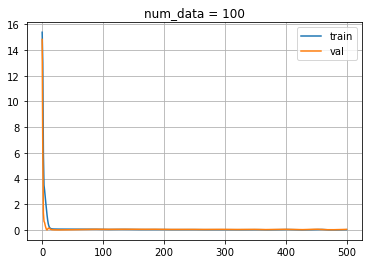

save model when [100] 
num_data: 200
torch.Size([3, 1000, 7851])
shape of data: torch.Size([600, 7851])
shape of w_avg: torch.Size([200, 7851])
[100/500]  Train Loss: 0.07504111284215469  Val Loss: 0.07119694676366635
[200/500]  Train Loss: 0.06825065431185066  Val Loss: 0.0648052195640048
[300/500]  Train Loss: 0.06612053363933228  Val Loss: 0.06181664479081519
[400/500]  Train Loss: 0.0654035750660114  Val Loss: 0.05975179843371734
[500/500]  Train Loss: 0.06518261546152644  Val Loss: 0.058151774678844956


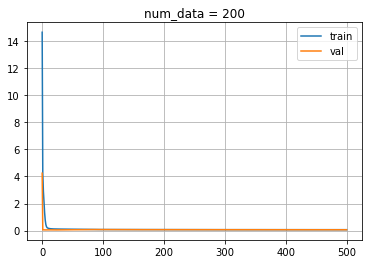

save model when [200] 
num_data: 400
torch.Size([3, 1000, 7851])
shape of data: torch.Size([1200, 7851])
shape of w_avg: torch.Size([400, 7851])
[100/500]  Train Loss: 0.24975580445898232  Val Loss: 0.17930783257470467
[200/500]  Train Loss: 0.23357480476843193  Val Loss: 0.18906653985904995
[300/500]  Train Loss: 0.21902464047743705  Val Loss: 0.17984805019805208
[400/500]  Train Loss: 0.21033795064504374  Val Loss: 0.1831825852044858
[500/500]  Train Loss: 0.20551480349968188  Val Loss: 0.18413447041821202


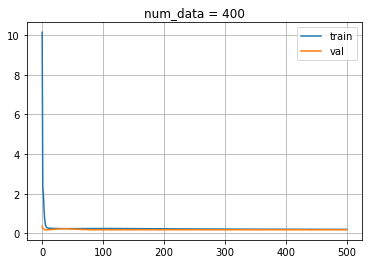

save model when [400] 
num_data: 500
torch.Size([3, 1000, 7851])
shape of data: torch.Size([1500, 7851])
shape of w_avg: torch.Size([500, 7851])
[100/500]  Train Loss: 0.3200167878845241  Val Loss: 0.2893825510144234
[200/500]  Train Loss: 0.31588569830055346  Val Loss: 0.28767704890109597
[300/500]  Train Loss: 0.31403735238825903  Val Loss: 0.2866325913928449
[400/500]  Train Loss: 0.3124391515017487  Val Loss: 0.2893688803818077
[500/500]  Train Loss: 0.3111948262201622  Val Loss: 0.287757849029731


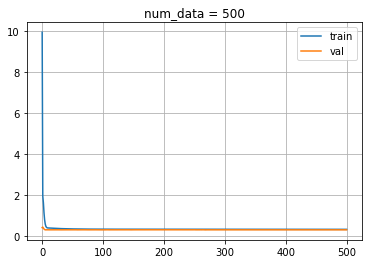

save model when [500] 
num_data: 700
torch.Size([3, 1000, 7851])
shape of data: torch.Size([2100, 7851])
shape of w_avg: torch.Size([700, 7851])
[100/500]  Train Loss: 0.6187866570802206  Val Loss: 1.115499768193279
[200/500]  Train Loss: 0.6186400391676995  Val Loss: 1.1415638360061815
[300/500]  Train Loss: 0.619334307009454  Val Loss: 1.0841204341367952
[400/500]  Train Loss: 0.6195176952015442  Val Loss: 0.9993102163741631
[500/500]  Train Loss: 0.6173983704689557  Val Loss: 0.9321269356462706


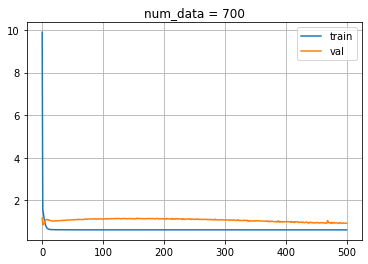

save model when [700] 
num_data: 1000
torch.Size([3, 1000, 7851])
shape of data: torch.Size([3000, 7851])
shape of w_avg: torch.Size([1000, 7851])
[100/500]  Train Loss: 1.2528877493791515  Val Loss: 1.0898539900220932
[200/500]  Train Loss: 1.233787489363458  Val Loss: 1.0892614605277777
[300/500]  Train Loss: 1.2286811455478892  Val Loss: 1.0984965217113496
[400/500]  Train Loss: 1.2229743043147028  Val Loss: 1.095602064523846
[500/500]  Train Loss: 1.2208996393415146  Val Loss: 1.0934639706648885


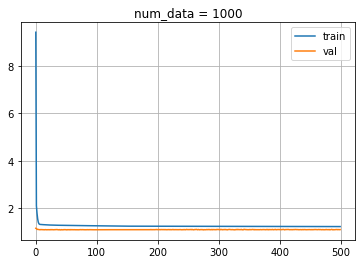

save model when [1000] 


In [25]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ====== Optimizer & Training ====== #
args.lr = 0.0001
args.num_epochs = 500

# ====== Model Capacity ===== #
args.hidden_dim = 15

# ====== Data Loading ====== #
args.batch_size = 2
args.num_clients = 3
args.num_data = 500
args.reverse = False


make_dir(args)

name_var = 'num_data'
list_var = [100, 200, 400, 500, 700, 1000]

set = load_data(args)
set = set.view(3, -1 ,7851)

for var in list_var:
    print(f"{name_var}: {var}")
    setattr(args, name_var, var)
    print(set.shape)

    num_set = set[:, torch.randperm(args.num_data), :]
    w_avg = torch.mean(num_set, dim = 0)
    num_set = num_set.reshape(-1, 7851)
    print(f"shape of data: {num_set.shape}")
    print(f"shape of w_avg: {w_avg.shape}")

    train_set = num_set[:int(len(num_set)*0.8)]
    val_set = num_set[int(len(num_set)*0.8):]
    train_w_set = w_avg[:int(len(w_avg)*0.8)]
    val_w_set = w_avg[int(len(w_avg)*0.8):]

    partition = {'train':train_set, 'val':val_set, 'train_w_avg':train_w_set, 'val_w_avg':val_w_set}

    encoder, decoder, train_losses, val_losses = experiment(partition, deepcopy(args))
    plot_loss(var, name_var, train_losses, val_losses)
    w_avg_save_model(encoder, decoder, var, args)

##### **Ex2) Reverse Num_data**

Directories not created because they already exist
num_data: 50
shape of data: torch.Size([3, 1000, 7851])
shape of data: torch.Size([150, 7851])
shape of w_avg: torch.Size([50, 7851])
[100/500]  Train Loss: 0.011965390760451555  Val Loss: 0.010758783295750618
[200/500]  Train Loss: 0.020502195134758948  Val Loss: 0.017372498847544195
[300/500]  Train Loss: 0.014919363847002386  Val Loss: 0.005745616694912315
[400/500]  Train Loss: 0.012482096545863897  Val Loss: 0.008167720679193736
[500/500]  Train Loss: 0.0462890662252903  Val Loss: 0.007378911273553968


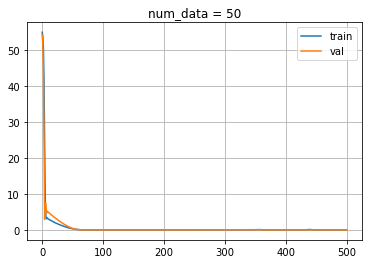

save model when [50] 
num_data: 100
shape of data: torch.Size([3, 1000, 7851])
shape of data: torch.Size([300, 7851])
shape of w_avg: torch.Size([100, 7851])
[100/500]  Train Loss: 0.019643917586654423  Val Loss: 0.01590622521471232
[200/500]  Train Loss: 0.02995192090747878  Val Loss: 0.010895423730835319
[300/500]  Train Loss: 0.028769862756598742  Val Loss: 0.010648085968568921
[400/500]  Train Loss: 0.02874272319022566  Val Loss: 0.010165478941053152
[500/500]  Train Loss: 0.028673958854051308  Val Loss: 0.009904092538636177


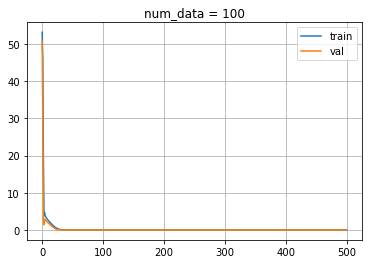

save model when [100] 
num_data: 200
shape of data: torch.Size([3, 1000, 7851])
shape of data: torch.Size([600, 7851])
shape of w_avg: torch.Size([200, 7851])
[100/500]  Train Loss: 0.08727888553403318  Val Loss: 0.08786199637688696
[200/500]  Train Loss: 0.08129046910034958  Val Loss: 0.09645472408737987
[300/500]  Train Loss: 0.07691293433017563  Val Loss: 0.09821655286941677
[400/500]  Train Loss: 0.07369379052252042  Val Loss: 0.10071121687069536
[500/500]  Train Loss: 0.07115997364599025  Val Loss: 0.09816829658811912


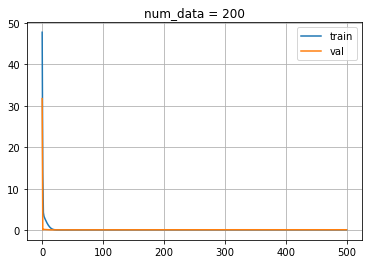

save model when [200] 
num_data: 400
shape of data: torch.Size([3, 1000, 7851])
shape of data: torch.Size([1200, 7851])
shape of w_avg: torch.Size([400, 7851])
[100/500]  Train Loss: 0.21752972690446767  Val Loss: 0.17391178830584977
[200/500]  Train Loss: 0.2161734414534294  Val Loss: 0.17607503486215137
[300/500]  Train Loss: 0.21509204380054142  Val Loss: 0.1792472752626054
[400/500]  Train Loss: 0.2138813519704854  Val Loss: 0.1817474603652954
[500/500]  Train Loss: 0.2128359306283528  Val Loss: 0.18099636426195503


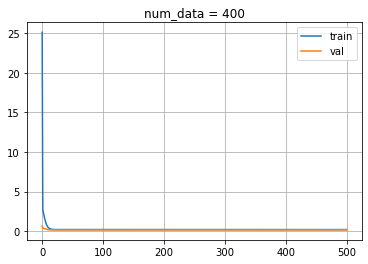

save model when [400] 
num_data: 500
shape of data: torch.Size([3, 1000, 7851])
shape of data: torch.Size([1500, 7851])
shape of w_avg: torch.Size([500, 7851])
[100/500]  Train Loss: 0.3237249766802415  Val Loss: 0.2980215805396438
[200/500]  Train Loss: 0.31961671959375965  Val Loss: 0.29110084360465405
[300/500]  Train Loss: 0.31721080196788537  Val Loss: 0.28874778749421237
[400/500]  Train Loss: 0.316703319788212  Val Loss: 0.3076970253884792
[500/500]  Train Loss: 0.31606444359058516  Val Loss: 0.2924762688204646


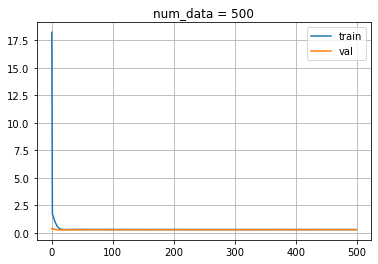

save model when [500] 
num_data: 700
shape of data: torch.Size([3, 1000, 7851])
shape of data: torch.Size([2100, 7851])
shape of w_avg: torch.Size([700, 7851])
[100/500]  Train Loss: 0.6096142899145239  Val Loss: 0.6046164333155113
[200/500]  Train Loss: 0.602849204555553  Val Loss: 0.6024265717315886
[300/500]  Train Loss: 0.5998355913000913  Val Loss: 0.5996902092226915
[400/500]  Train Loss: 0.5970865254007679  Val Loss: 0.5968787095575993
[500/500]  Train Loss: 0.5948846465666845  Val Loss: 0.6008850412709372


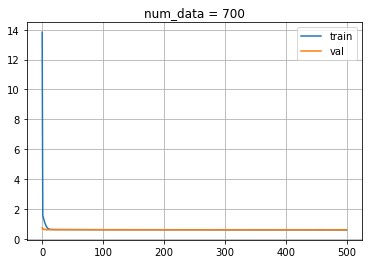

save model when [700] 
num_data: 1000
shape of data: torch.Size([3, 1000, 7851])
shape of data: torch.Size([3000, 7851])
shape of w_avg: torch.Size([1000, 7851])
[100/500]  Train Loss: 1.2452360812271945  Val Loss: 1.388727725390345
[200/500]  Train Loss: 1.2225362477684394  Val Loss: 1.3452443153224884
[300/500]  Train Loss: 1.2018327106744982  Val Loss: 1.3391209777304902
[400/500]  Train Loss: 1.1932421013177372  Val Loss: 1.2925309702381491
[500/500]  Train Loss: 1.188902010563761  Val Loss: 1.3043374760774895


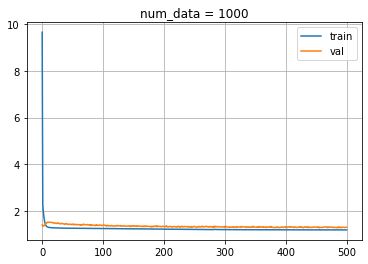

save model when [1000] 


In [38]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ====== Optimizer & Training ====== #
args.lr = 0.0001
args.num_epochs = 500

# ====== Model Capacity ===== #
args.hidden_dim = 15

# ====== Data Loading ====== #
args.batch_size = 2
args.num_clients = 3
args.num_data = 500
args.reverse = True

make_dir(args)

name_var = 'num_data'
list_var = [50, 100, 200, 400, 500, 700, 1000]

set = load_data(args)
set = set.view(3, -1 ,7851)

for var in list_var:
    print(f"{name_var}: {var}")
    setattr(args, name_var, var)
    print(f"shape of data: {set.shape}")

    num_set = set[:, 999-torch.randperm(args.num_data), :]
    w_avg = torch.mean(num_set, dim = 0)
    num_set = num_set.reshape(-1, 7851)
    print(f"shape of data: {num_set.shape}")
    print(f"shape of w_avg: {w_avg.shape}")

    train_set = num_set[:int(len(num_set)*0.8)]
    val_set = num_set[int(len(num_set)*0.8):]
    train_w_set = w_avg[:int(len(w_avg)*0.8)]
    val_w_set = w_avg[int(len(w_avg)*0.8):]

    partition = {'train':train_set, 'val':val_set, 'train_w_avg':train_w_set, 'val_w_avg':val_w_set}

    encoder, decoder, train_losses, val_losses = experiment(partition, deepcopy(args))
    plot_loss(var, name_var, train_losses, val_losses)
    w_avg_save_model(encoder, decoder, var, args)